In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import scipy.stats as ss
from scipy.interpolate import interp1d

rez=600

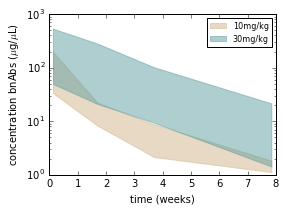

In [11]:
#process raw PK data (clicked on from Yunda data)

d10=pd.read_csv('data/decays10.csv',names=['time','conc'])
d30=pd.read_csv('data/decays30.csv',names=['time','conc'])

dtpts=np.array([1,12,26,55])

inds10=[0,8,17,28,36]
inds30=[0,10,22,34,43]

newd10=[]
newd30=[]

for j in range(len(inds10)-1):
    newd10.append(d10.conc[inds10[j]:inds10[j+1]].tolist())
for j in range(len(inds30)-1):
    newd30.append(d30.conc[inds30[j]:inds30[j+1]].tolist())

newd10=pd.DataFrame(newd10)
newd30=pd.DataFrame(newd30)

min10=np.min(newd10[newd10>1],1)
min30=np.min(newd30[newd30>1],1)

max10=np.max(newd10,1)
max30=np.max(newd30,1)

plt.figure(figsize=(4,3),dpi=rez)

plt.fill_between(dtpts/7,min10,max10,color='tan',alpha=0.5)
plt.fill_between(dtpts/7,min30,max30,color='cadetblue',alpha=0.5)
plt.yscale('log')
plt.ylabel('concentration bnAbs ($\mu$g/$\mu$L)')
plt.xlabel('time (weeks)')
plt.legend(['10mg/kg','30mg/kg'],fontsize=8)
plt.tight_layout()
plt.savefig('figures/decay_swaths.pdf')  # No warning now


/Users/danielreeves/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


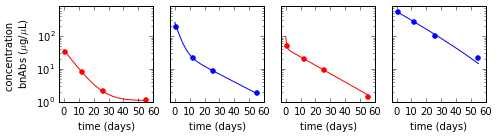

In [17]:
#fit the pk model for decay kinetics of Abs
def Ab_conc(t,Y1,Y2,k1,k2):
    return Y1*np.exp(-k1*t)+Y2*np.exp(-k2*t)

t=np.linspace(0,55,1e3)

dlist=[min10,max10,min30,max30]

plist=[]
clist=['red','blue','red','blue']

fig,axarr=plt.subplots(1,4,sharex=True,sharey=True, figsize=(7,2))
for i in range(4):
    p0=(dlist[i][0],100,0.1,0.01)
    popt=opt.curve_fit(Ab_conc, dtpts, dlist[i], p0, ftol=1e-10, gtol=1e-10, maxfev=10**5)

    Y1,Y2,k1,k2=popt[0]

    plist.append(popt[0])
    
    axarr[i].plot(t,Ab_conc(t,Y1,Y2,k1,k2),color=clist[i])
    axarr[i].scatter(dtpts,dlist[i],color=clist[i])
    axarr[i].set_xlabel('time (days)')

axarr[0].set_yscale('log')
axarr[0].set_ylabel('concentration \n bnAbs ($\mu$g/$\mu$L)')
axarr[0].set_ylim([1,800])
axarr[0].set_xlim([-3,60])
plt.tight_layout()

plt.savefig('figures/fit_decays.pdf')  # No warning now


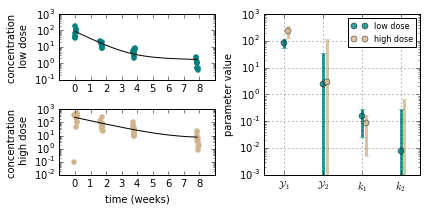

In [15]:
#fit to all data at once

param_names=['$\mathcal{Y}_1$','$\mathcal{Y}_2$','$k_1$','$k_2$']

popt10,pcov10=opt.curve_fit(Ab_conc, d10.time, d10.conc, p0, ftol=1e-10, gtol=1e-10, maxfev=10**4)
Y1,Y2,k1,k2=popt10

plt.figure(figsize=(6,3),dpi=rez)

plt.subplot(221)
plt.semilogy(t/7,Ab_conc(t,Y1,Y2,k1,k2),color='k')
plt.scatter(d10.time/7, d10.conc, color='teal')
plt.xticks(range(9))
#plt.gca().locator_params(nbins=5)
plt.ylabel('concentration \n low dose')

plt.subplot(122)
#plt.bar(range(4),popt)
plt.errorbar(range(4),popt10,np.sqrt(np.diag(pcov10)),color='teal',marker='o',ls='',lw=3,alpha=0.8)
plt.xticks(range(4),param_names)
plt.yscale('log')
plt.grid('on')
plt.ylabel('parameter value')

#print(popt,np.sqrt(np.diag(pcov)))

popt30,pcov30=opt.curve_fit(Ab_conc, d30.time, d30.conc, p0, ftol=1e-10, gtol=1e-10, maxfev=10**4)
Y1,Y2,k1,k2=popt30

plt.subplot(122)
#plt.bar(range(4),popt)
plt.errorbar(np.arange(4)+0.1,popt30,np.sqrt(np.diag(pcov30)),color='tan',marker='o',ls='',lw=3,alpha=0.8)
plt.xlim([-0.5,3.5])
plt.xticks(range(4),param_names)
plt.yscale('log')
plt.grid('on')
plt.ylabel('parameter value')
plt.legend(['low dose','high dose'],fontsize=8)

plt.subplot(223)
plt.semilogy(t/7,Ab_conc(t,Y1,Y2,k1,k2),color='k')
plt.scatter(d30.time/7, d30.conc, color='tan')
plt.ylabel('concentration \n high dose')
plt.xlabel('time (weeks)')
plt.xticks(range(9))

#print(popt,np.sqrt(np.diag(pcov)))

plt.tight_layout()
plt.savefig('figures/fit_decay_stats.pdf')  # No warning now


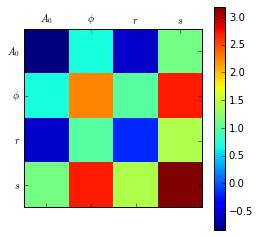

In [5]:

popt_mat=np.transpose(np.matrix(popt10))*np.matrix(popt10)

plt.matshow(np.log10(np.abs(pcov10/popt_mat)))
plt.colorbar()
plt.xticks(range(4),param_names)
plt.yticks(range(4),param_names)

plt.savefig('figures/fit_decay_covs.pdf')  # No warning now


/Users/danielreeves/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/danielreeves/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


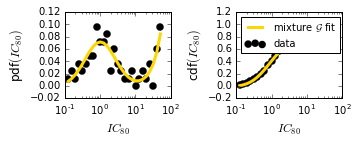

In [6]:
IC80 = np.array([
        [0.174,0.239,0.309,0.287,0.184,0.410,0.539,0.388,0.783,0.648],
        [3.801,13.967,32.949,34.874,37.982,50.565,47.721,38.042,49.204,47.176],
        [2.042,1.238,1.059,1.309,1.087,0.878,0.854,0.442,0.317,0.260],
        [0.685,0.965,1.179,0.801,0.801,0.811,1.006,0.654,0.478,0.286,0.126],
        [5.335,2.536,1.654,1.650,1.721,1.223,0.796,0.662,0.511,0.564],
        [6.206,2.486,2.705,1.551,1.322,1.052,0.803],
        [42.586,40.768,35.319,41.305,46.946,24.380,21.407,18.528,22.946,15.874,12.792,7.985,8.204,3.383,1.297],
        [2.836,3.223,3.876,2.286,2.383,1.978,1.595,1.552,1.134,1.555]])

log80=np.log10(np.hstack(IC80)) #flatten it out for all patients

binwidth=0.1
nbins=np.ceil((max(log80)-min(log80))/binwidth)
bingrid=np.linspace(min(log80),max(log80),nbins)

p_x,x = np.histogram(log80,bins=nbins)

p0=2,-0.01, 0.3, 1.7, 0.2

def bimodal(x,scl,mu1,sig1,mu2,sig2):
    gmix=scl*ss.norm.pdf(x,mu1,sig1)+ss.norm.pdf(x,mu2,sig2)
    return gmix/sum(gmix) #make it a probability

def fit_cdf(logIC80,scl,mu1,sig1,mu2,sig2):
    pdf=bimodal(logIC80,scl,mu1,sig1,mu2,sig2)
    return np.cumsum(pdf)
    
#fit the cdfs
popt=opt.curve_fit(fit_cdf, bingrid, np.cumsum(p_x/sum(p_x)), p0, ftol=1e-5, gtol=1e-5, maxfev=10**4)

scl,mu1,sig1,mu2,sig2=popt[0]
p_fit=bimodal(bingrid,scl,mu1,sig1,mu2,sig2)

plt.figure(figsize=(5,2),dpi=rez)

plt.subplot(121)
plt.scatter(10**bingrid,p_x/sum(p_x),lw=3,color='k')
plt.semilogx(10**bingrid,p_fit,lw=3,color='gold')
#plt.xlabel('$IC_{80}$',fontsize=12)
plt.ylabel('pdf$(IC_{80})$',fontsize=12)
plt.xlabel('$IC_{80}$',fontsize=12)

plt.subplot(122)
cdf=fit_cdf(bingrid,scl,mu1,sig1,mu2,sig2)
plt.scatter(10**bingrid,np.cumsum(p_x/sum(p_x)),lw=3,color='k')
plt.semilogx(10**bingrid,cdf,lw=3,color='gold')
plt.xlabel('$IC_{80}$',fontsize=12)
plt.ylabel('cdf$(IC_{80})$',fontsize=12)
plt.legend([r'mixture $\mathcal{G}$ fit','data'],loc=2,fontsize=10)
#plt.xlim([-1,2])

plt.tight_layout()
plt.savefig('figures/fit_dist.pdf')  # No warning now


/Users/danielreeves/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/danielreeves/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


(array([  38.,   77.,  136.,  224.,  158.,  100.,   32.,   26.,   57.,  152.]),
 array([-0.88888197, -0.62984312, -0.37080427, -0.11176542,  0.14727342,
         0.40631227,  0.66535112,  0.92438996,  1.18342881,  1.44246766,
         1.70150651]),
 <a list of 10 Patch objects>)

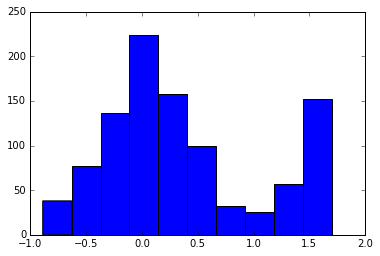

In [7]:
import scipy.interpolate as interpolate

hist, bin_edges = np.histogram(log80, bins=nbins, density=True)
cum_values = np.zeros(bin_edges.shape)
cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
inv_cdf = interpolate.interp1d(cum_values, bin_edges)
r = np.random.rand(1000)
plt.hist(inv_cdf(r))


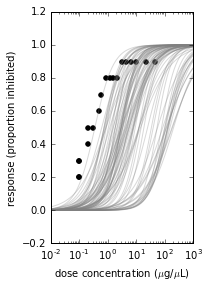

In [8]:
#functions for Ab IC80
def response80(dose,IC80,hill):
    IC50 = IC80*4**(1/hill) 
    res = 1/(1+(dose/IC50)**-hill)
    return res

plt.figure(figsize=(3,4),dpi=rez)
#data?
dose_response=pd.read_csv('data/vrc01_doseresponse.csv',names=['dose','response'])
plt.scatter(dose_response['dose'],dose_response['response'],color='k')

hmin,hmax=0.8,1.8

#all from Lynch
dose=np.logspace(-3,3,100)
for i in range(len(log80)):
    plt.plot(dose,response80(dose,10**log80[i],np.random.uniform(hmin,hmax)),color='gray',alpha=0.3)

plt.xlabel('dose concentration ($\mu$g/$\mu$L)')
plt.ylabel('response (proportion inhibited)')
plt.xscale('log')
plt.xlim([0.01,1e3])

plt.tight_layout()
plt.gcf().savefig('figures/doseresponse.pdf')  # No warning now


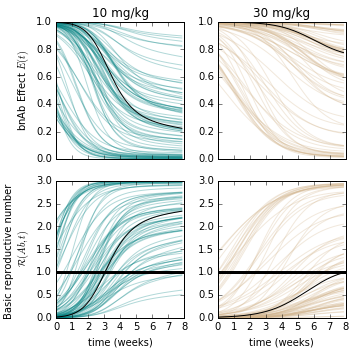

In [9]:
#plot proportion inhibited over time
t=np.linspace(0,55,1e3)

R0=3

fig,axarr=plt.subplots(2,2,sharex=True,dpi=rez,figsize=(5,5))

c1,c2,r1,r2=popt10 #10mg/kg range
Ab=Ab_conc(t,c1,c2,r1,r2)
for i in range(len(log80)):
    axarr[0][0].plot(t/7,response80(Ab,10**log80[i],np.random.uniform(hmin,hmax)),color='teal',alpha=0.3)    
    axarr[1][0].plot(t/7,R0*(1-response80(Ab,10**log80[i],np.random.uniform(hmin,hmax))),color='teal',alpha=0.3)    
axarr[0][0].plot(t/7,response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax)),color='black')    
axarr[1][0].plot(t/7,R0*(1-response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax))),color='black')    

c1,c2,r1,r2=popt30 #30mg/kg range
Ab=Ab_conc(t,c1,c2,r1,r2)
for i in range(len(log80)):
    axarr[0][1].plot(t/7,response80(Ab,10**log80[i],np.random.uniform(hmin,hmax)),color='tan',alpha=0.3)    
    axarr[1][1].plot(t/7,R0*(1-response80(Ab,10**log80[i],np.random.uniform(hmin,hmax))),color='tan',alpha=0.3)    
    
axarr[0][1].plot(t/7,response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax)),color='black')    
axarr[1][1].plot(t/7,R0*(1-response80(Ab,10**np.median(log80),np.random.uniform(hmin,hmax))),color='black')    

for j in range(2):
    axarr[1][j].set_xlabel('time (weeks)')
    axarr[1][j].axhline(1,color='k',lw=3)

axarr[0][0].set_title('10 mg/kg')
axarr[0][1].set_title('30 mg/kg')
axarr[0][0].set_ylabel('bnAb Effect $E(t)$')
axarr[1][0].set_ylabel('Basic reproductive number \n $\mathcal{R}(Ab,t)$')#,fontsize=13)
axarr[0][0].set_xticks(range(9))

plt.tight_layout()
plt.savefig('figures/inhibition_R0.pdf')  # No warning now


In [12]:
#100 theoretical curves drawing from all distributions

lynch=pd.read_csv('data/vrc01_lynch_dbr.csv')#,columns=['IC50','IC80','h'])

,IC50,IC80,h
0,0.229,0.569,2.6
1,0.229,1.080,1.6
2,0.075,0.431,1.2
3,0.144,0.678,0.8
4,0.074,0.288,1.2
5,0.128,0.526,1.1
6,0.570,0.177,1.0
7,0.119,0.414,1.1
8,0.560,0.190,1.3
9,0.089,0.299,1.0
